In [3]:
import requests
import pandas as pd
import numpy as np
import pymysql

In [4]:
#get data as json files
url='https://ghoapi.azureedge.net/api/NCD_BMI_30C'
url1='https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C'
url2='https://ghoapi.azureedge.net/api/NCD_BMI_18C'
url3='https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C'
response=requests.get(url)
response1=requests.get(url1)
response2=requests.get(url2)
response3=requests.get(url3)
ob_ad=response.json()
ob_ch=response1.json()
mal_ad=response2.json()
mal_ch=response3.json()


In [39]:
ob_ch.keys()

dict_keys(['@odata.context', 'value'])

In [6]:
ob_ad.keys()

dict_keys(['@odata.context', 'value'])

In [5]:
mal_ad.keys()


dict_keys(['@odata.context', 'value'])

In [6]:
#pass the required data to DataFrames
df=pd.DataFrame(ob_ad['value'])
df1=pd.DataFrame(ob_ch['value'])
df2=pd.DataFrame(mal_ad['value'])
df3=pd.DataFrame(mal_ch['value'])

In [7]:
#add column age_group
df['age_group']='Adults'
df1['age_group']='Children'
df2['age_group']='Adults'
df3['age_group']='Children'

In [8]:
#Concatenate dataframes for obesity and malnutrition
df_obesity=pd.concat([df,df1])
df_malnutrition=pd.concat([df2,df3])

In [9]:
#filter data for 2012 to 2022
df_malnutrition=df_malnutrition[df_malnutrition['TimeDim']>2011]
df_obesity=df_obesity[df_obesity['TimeDim']>2011]

In [10]:
#drop extra columns
df_obesity.drop(['Id','IndicatorCode','SpatialDimType','TimeDimType','ParentLocationCode','Dim1Type','Dim2Type','Dim2','Dim3Type','Dim3','DataSourceDimType','DataSourceDim','Value','Comments','Date','TimeDimensionValue','TimeDimensionBegin','TimeDimensionEnd'],axis=1,inplace=True)

df_malnutrition.drop(['Id','IndicatorCode','SpatialDimType','TimeDimType','ParentLocationCode','Dim1Type','Dim2Type','Dim2','Dim3Type','Dim3','DataSourceDimType','DataSourceDim','Value','Comments','Date','TimeDimensionValue','TimeDimensionBegin','TimeDimensionEnd'],axis=1,inplace=True)

In [11]:
#rename columns
df_obesity=df_obesity.rename(columns={'TimeDim':'Year','Dim1':'Gender','NumericValue':'Mean_Estimate','Low':'LowerBound','High':'UpperBound','ParentLocation':'Region','SpatialDim':'Country'})

df_malnutrition=df_malnutrition.rename(columns={'TimeDim':'Year','Dim1':'Gender','NumericValue':'Mean_Estimate','Low':'LowerBound','High':'UpperBound','ParentLocation':'Region','SpatialDim':'Country'})

In [36]:
df_obesity=df_obesity.rename(columns={'obesity_level ':'obesity_level'})

In [13]:
#standardize the values of 'Gender' feature
df_obesity.loc[df_obesity['Gender']=='SEX_MLE','Gender']='Male'
df_obesity.loc[df_obesity['Gender']=='SEX_FMLE','Gender']='Female'
df_obesity.loc[df_obesity['Gender']=='SEX_BTSX','Gender']='Both'

In [14]:
#standardize the values of 'Gender' feature
df_malnutrition.loc[df_malnutrition['Gender']=='SEX_MLE','Gender']='Male'
df_malnutrition.loc[df_malnutrition['Gender']=='SEX_FMLE','Gender']='Female'
df_malnutrition.loc[df_malnutrition['Gender']=='SEX_BTSX','Gender']='Both'

In [15]:
import pycountry

In [16]:
def counName(Alpha3):
    # Dictionary for special or missing codes
    special_cases = {
                    'GLOBAL': 'Global',
                    'WB_LMI': 'Low & Middle Income',
                    'WB_HI': 'High Income',
                    'WB_LI': 'Low Income',
                    'EMR': 'Eastern Mediterranean Region',
                    'EUR': 'Europe',
                    'AFR': 'Africa',
                    'SEAR': 'South-East Asia Region',
                    'WPR': 'Western Pacific Region',
                    'AMR': 'Americas Region',
                    'WB_UMI': 'Upper Middle Income'}

    cont = pycountry.countries.get(alpha_3=Alpha3)
    
    if cont:
        return cont.name
    else:
        Alpha3 in special_cases
        return special_cases[Alpha3]



In [17]:
print(counName('WB_LI'))

Low Income


In [18]:
df_obesity['Country']=df_obesity['Country'].apply(counName)
df_malnutrition['Country']=df_malnutrition['Country'].apply(counName)

In [19]:
df_obesity['CI_Width']=df_obesity['UpperBound']- df_obesity['LowerBound']
df_malnutrition['CI_Width']=df_malnutrition['UpperBound']- df_malnutrition['LowerBound']

In [20]:
conditions = [
    (df_obesity['Mean_Estimate'] >= 30),
    (df_obesity['Mean_Estimate'] >=25) & (df_obesity['Mean_Estimate'] <=29.9),
    (df_obesity['Mean_Estimate'] < 25)
]
choices = ['High', 'Moderate', 'Low']

df_obesity['obesity_level '] = np.select(conditions, choices, default='Invalid') # default for unhandled cases



In [21]:
conditions_mal = [
    (df_malnutrition['Mean_Estimate'] >= 20),
    (df_malnutrition['Mean_Estimate'] >=10) & (df_malnutrition['Mean_Estimate'] <=19.9),
    (df_malnutrition['Mean_Estimate'] < 10)
]
choices_mal = ['High', 'Moderate', 'Low']

df_malnutrition['malnutrition_level'] = np.select(conditions_mal, choices_mal, default='Invalid') # default for unhandled cases


In [22]:
df_malnutrition.shape


(27720, 10)

In [23]:
df_malnutrition.columns

Index(['Country', 'Region', 'Gender', 'Year', 'Mean_Estimate', 'LowerBound',
       'UpperBound', 'age_group', 'CI_Width', 'malnutrition_level'],
      dtype='object')

In [24]:
df_malnutrition.dtypes

Country                object
Region                 object
Gender                 object
Year                    int64
Mean_Estimate         float64
LowerBound            float64
UpperBound            float64
age_group              object
CI_Width              float64
malnutrition_level     object
dtype: object

In [ ]:
df_malnutrition.describe()

In [ ]:
df_malnutrition.info()

In [ ]:
df_malnutrition.isnull().sum()

In [57]:
df_obesity.shape

(27720, 10)

In [37]:
df_obesity.columns

Index(['Country', 'Region', 'Year', 'Gender', 'Mean_Estimate', 'LowerBound',
       'UpperBound', 'age_group', 'CI_Width', 'obesity_level'],
      dtype='object')

In [35]:
df_obesity.dtypes

Country           object
Region            object
Year               int64
Gender            object
Mean_Estimate    float64
LowerBound       float64
UpperBound       float64
age_group         object
CI_Width         float64
obesity_level     object
dtype: object

In [34]:
df_obesity.describe()

,Year,Mean_Estimate,LowerBound,UpperBound,CI_Width
count,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,2017.000000,12.761040,9.393155,17.068488,7.675334
std,3.162335,10.858925,9.893854,12.395013,6.616899
min,2012.000000,0.265672,0.077541,0.547848,0.216695
25%,2014.000000,4.753964,2.354433,7.875503,2.926708
50%,2017.000000,9.944541,6.506534,13.704382,5.480536
75%,2020.000000,17.482417,12.697752,23.986050,10.338880
max,2022.000000,80.609250,74.365371,87.868512,40.554062


In [ ]:
df_obesity.info()

In [ ]:
df_obesity.isnull().sum()

In [44]:
df_obesity['Region'].dtypes


dtype('O')

In [26]:
df_obesity.head()

,Country,Region,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,CI_Width,obesity_level
1,Cambodia,Western Pacific,2014,Both,2.470646,2.105896,2.886291,Adults,0.780395,Low
4,Viet Nam,Western Pacific,2012,Both,0.818540,0.714215,0.930910,Adults,0.216695,Low
7,Azerbaijan,Europe,2021,Male,18.519711,14.439055,22.837320,Adults,8.398265,Low
9,Brunei Darussalam,Western Pacific,2018,Male,27.394348,23.271655,31.743392,Adults,8.471737,Moderate
10,Dominican Republic,Americas,2012,Female,26.434815,24.378446,28.612390,Adults,4.233944,Moderate


In [27]:
import matplotlib.pyplot as plt

In [52]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Sony\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [28]:
import seaborn as sns

{'whiskers': [<matplotlib.lines.Line2D at 0x7e654cd1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e654cfb10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e5c267750>,
 'medians': [<matplotlib.lines.Line2D at 0x7e654cfd90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e654cfed0>,
 'means': []}

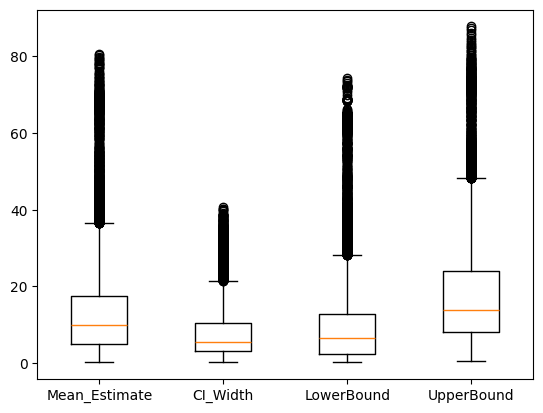

In [29]:
plt.boxplot([df_obesity['Mean_Estimate'],df_obesity['CI_Width'],df_obesity['LowerBound'],df_obesity['UpperBound']],tick_labels=['Mean_Estimate', 'CI_Width', 'LowerBound','UpperBound'])

(array([6884., 7250., 4378., 2821., 1903., 1337., 1001.,  727.,  517.,
         355.,  252.,  163.,   82.,   34.,   16.]),
 array([ 0.21669479,  2.90585259,  5.59501039,  8.28416819, 10.97332599,
        13.66248379, 16.35164159, 19.04079939, 21.7299572 , 24.419115  ,
        27.1082728 , 29.7974306 , 32.4865884 , 35.1757462 , 37.864904  ,
        40.5540618 ]),
 <BarContainer object of 15 artists>)

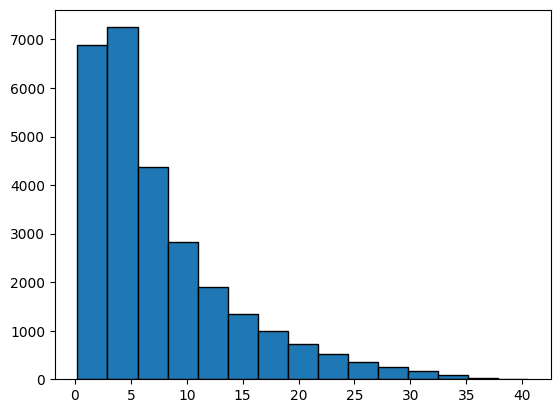

In [30]:
plt.hist(df_obesity['CI_Width'],bins=15,edgecolor='black')

(array([8331., 6698., 4923., 3103., 1969., 1237.,  604.,  363.,  164.,
          67.,   41.,   53.,  108.,   40.,   19.]),
 array([ 0.26567157,  5.62191013, 10.97814869, 16.33438726, 21.69062582,
        27.04686438, 32.40310294, 37.7593415 , 43.11558007, 48.47181863,
        53.82805719, 59.18429575, 64.54053431, 69.89677288, 75.25301144,
        80.60925   ]),
 <BarContainer object of 15 artists>)

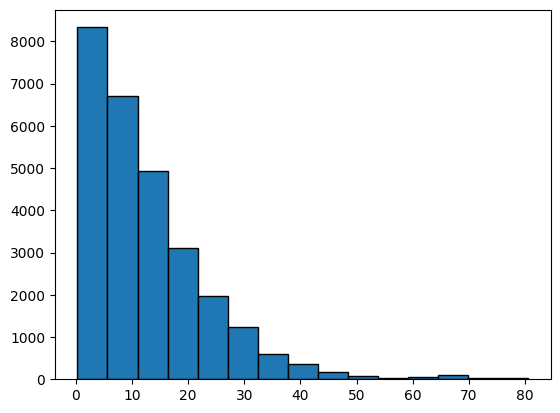

In [31]:
plt.hist(df_obesity['Mean_Estimate'],bins=15,edgecolor='black')

<BarContainer object of 27720 artists>

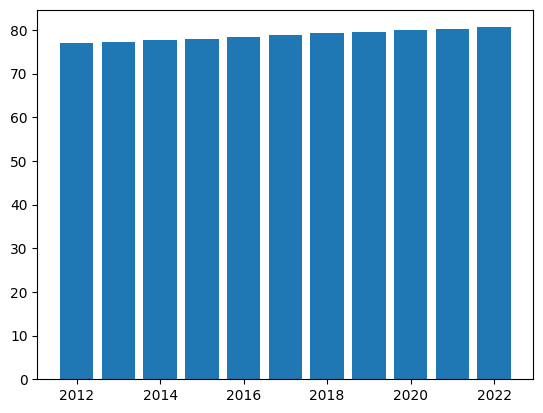

In [32]:
plt.bar(df_obesity['Year'],df_obesity['Mean_Estimate'])

In [80]:
df_obesity.head()

,Country,Region,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,CI_Width,obesity_level
0,Dominican Republic,Americas,2018,Female,31.578845,28.163901,35.033992,Adults,6.870091,High
3,Belarus,Europe,2013,Both,24.400960,21.804900,27.054971,Adults,5.250071,Low
5,Papua New Guinea,Western Pacific,2018,Male,13.964748,9.200430,19.930576,Adults,10.730146,Low
6,Eswatini,Africa,2017,Female,35.751587,31.537840,40.047240,Adults,8.509400,High
12,"Iran, Islamic Republic of",Eastern Mediterranean,2020,Male,17.487641,15.793777,19.245727,Adults,3.451950,Low


In [38]:
grouped = df_obesity.groupby('Year')['age_group'].size()
df1=pd.DataFrame(grouped)
df1

,age_group
Year,
2012,2520
2013,2520
2014,2520
2015,2520
2016,2520
2017,2520
2018,2520
2019,2520
2020,2520


In [39]:
pivot_df = df_obesity.pivot_table( values='CI_Width', index='Region', columns='Gender', aggfunc='max')
print(pivot_df)
type(pivot_df)


Gender                      Both     Female       Male
Region                                                
Africa                 19.997722  26.867781  28.889946
Americas               28.073689  35.483702  40.554062
Eastern Mediterranean  23.773528  29.259824  35.822329
Europe                 21.727229  26.306771  32.986241
South-East Asia        19.607382  22.205262  31.331276
Western Pacific        25.435587  33.315480  39.954137


pandas.core.frame.DataFrame

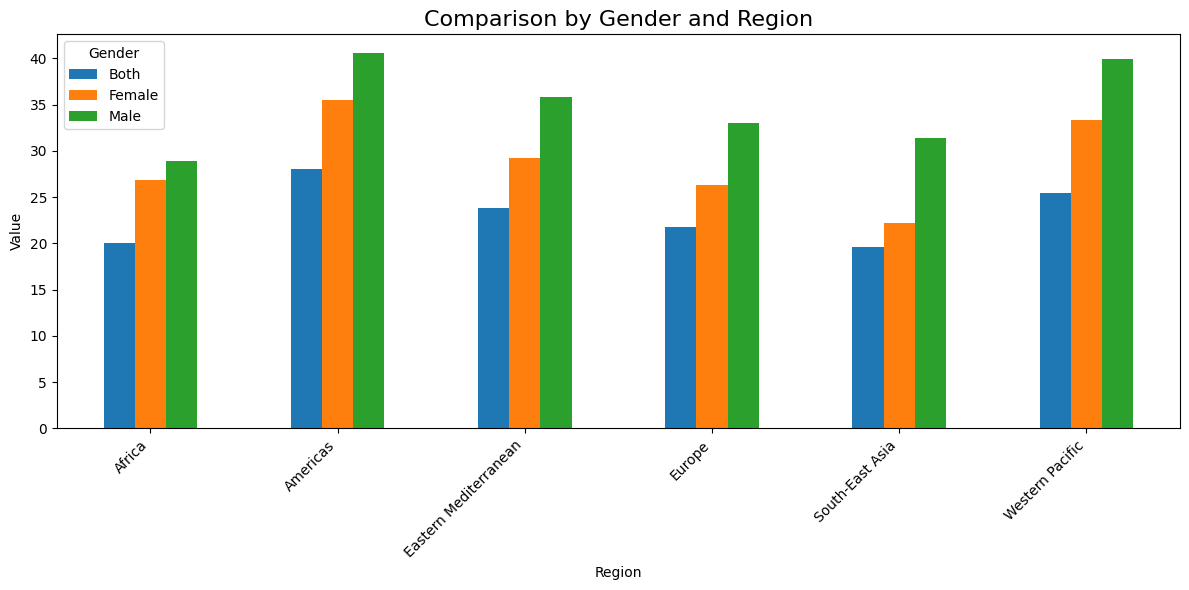

In [40]:


# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', ax=ax)

# Title and labels
ax.set_title("Comparison by Gender and Region", fontsize=16)
ax.set_ylabel("Value")
ax.set_xlabel("Region")
ax.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


Text(0, 0.5, 'Count')

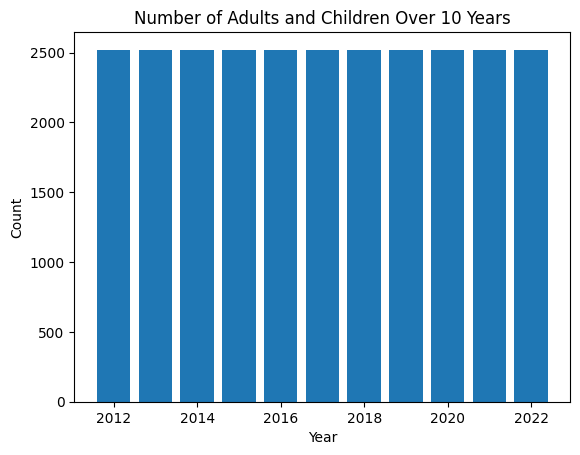

In [42]:
grouped = df_obesity.groupby('Year')['obesity_level'].size()
df1=pd.DataFrame(grouped)
# Plot

for group in df1.columns:
    plt.bar(df1.index, df1[group])
   #df1.plot(kind='bar', figsize=(10, 6))

plt.title('Number of Adults and Children Over 10 Years')
plt.xlabel('Year')
plt.ylabel('Count')






In [43]:
dbconn = pymysql.connect(
    host='localhost',
    user='root',
    password='<pass>',
    database='nutridb'    
)
#print(dbconn)

In [44]:
cur=dbconn.cursor()

In [42]:
df_malnutrition.head()


,Country,Region,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,CI_Width,malnutrition_level
0,Yemen,Eastern Mediterranean,2012,Female,9.195962,7.898650,10.620797,Adults,2.722147,Low
1,Central African Republic,Africa,2019,Both,6.739592,5.128323,8.627972,Adults,3.499649,Low
4,Philippines,Western Pacific,2019,Female,9.084384,7.234669,11.095012,Adults,3.860343,Low
6,Malawi,Africa,2021,Both,6.031211,4.912141,7.275361,Adults,2.363219,Low
8,"Iran, Islamic Republic of",Eastern Mediterranean,2020,Male,17.487641,15.793777,19.245727,Adults,3.451950,Moderate


In [45]:
createSql="create table obesity (Country varchar(50),Region varchar(50),Year int(10),Gender varchar(50),Mean_Estimate float,LowerBound float,UpperBound float,age_group varchar(20),CI_Width float,obesity_level varchar(10))"
createSql1="create table malnutrition (Country varchar(50),Region varchar(50),Year int(10),Gender varchar(50),Mean_Estimate float,LowerBound float,UpperBound float,age_group varchar(20),CI_Width float,Malnutrition_Level varchar(10))"
cur.execute(createSql)
cur.execute(createSql1)

0

In [46]:
for index,row in df_obesity.iterrows():
    cur.execute('INSERT INTO obesity(Country,Region,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,CI_Width,obesity_level) values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',( 
                    row['Country'], 
                    row['Region'], 
                    row['Year'],
                    row['Gender'],
					row['Mean_Estimate'],
                    row['LowerBound'],
					row['UpperBound'],
					row['age_group'],
					row['CI_Width'],
					row['obesity_level']))


In [47]:
for index,row in df_malnutrition.iterrows():
    cur.execute('INSERT INTO malnutrition(Country,Region,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,CI_Width,malnutrition_level) values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',( 
                    row['Country'], 
                    row['Region'], 
                    row['Year'],
                    row['Gender'],
					row['Mean_Estimate'],
                    row['LowerBound'],
					row['UpperBound'],
					row['age_group'],
					row['CI_Width'],
					row['malnutrition_level']))

In [48]:
dbconn.commit()

In [49]:
df_obesity.columns = df_obesity.columns.str.strip()

In [50]:
#Top 5 regions with the highest average obesity levels in the most recent year(2022)
sql1="select Region,count(*) as total from obesity where Year=2022 group by region order by total desc limit 5"
cur.execute(sql1)
res1=cur.fetchall()
df=pd.DataFrame(res1,columns=['Region','average obesity count'])
df

,Region,average obesity count
0,Europe,624
1,Africa,564
2,Americas,444
3,Western Pacific,360
4,Eastern Mediterranean,264


In [51]:
#Top 5 countries with highest obesity estimates
sql2="select country,max(mean_estimate) as estimate from obesity group by country order by estimate desc limit 5"
cur.execute(sql2)
res2=cur.fetchall()
df1=pd.DataFrame(res2,columns=['Country','Estimate'])
df1

,Country,Estimate
0,American Samoa,80.6093
1,Tonga,79.0533
2,Samoa,72.6159
3,Tokelau,72.4867
4,Cook Islands,71.5140


In [52]:
#Obesity trend in India over the years(Mean_estimate)
sql3="select year,avg(mean_estimate) as mean_estimate from obesity where country='India' group by year order by year asc"
cur.execute(sql3)
res3=cur.fetchall()
df2=pd.DataFrame(res3,columns=['Country','Estimate'])
df2

,Country,Estimate
0,2012,2.473178
1,2013,2.634653
2,2014,2.798749
3,2015,2.972813
4,2016,3.159576
5,2017,3.362175
6,2018,3.579292
7,2019,3.809013
8,2020,4.051149
9,2021,4.307816


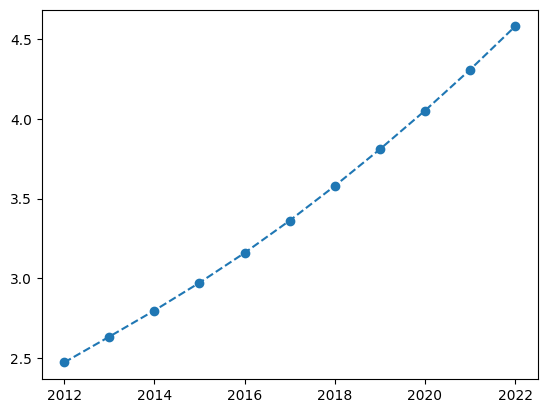

In [53]:
plt.plot(df2['Country'],df2['Estimate'],'o--')

In [54]:
#Average obesity by gender
sql4="select Gender,avg(mean_estimate) as mean_estimate from obesity group by gender"
cur.execute(sql4)
res4=cur.fetchall()
df3=pd.DataFrame(res4,columns=['Gender','Average Obesity'])
df3

,Gender,Average Obesity
0,Both,12.781969
1,Male,12.776696
2,Female,12.724456


In [55]:
#Country count by obesity level category and age group
sql5="select obesity_level,age_group,count(country)from obesity group by obesity_level,age_group"
cur.execute(sql5)
res5=cur.fetchall()
df4=pd.DataFrame(res5,columns=['Obesity level','Age Group','Number of countries'])
df4

,Obesity level,Age Group,Number of countries
0,Low,Adults,4327
1,Moderate,Adults,960
2,High,Adults,1620
3,Invalid,Adults,23
4,Low,Children,20037
5,High,Children,309
6,Moderate,Children,437
7,Invalid,Children,7


In [56]:
#Top 5 countries least reliable countries(with highest CI_Width)
sql6="select country,max(CI_width) from obesity group by country  order by max(CI_width) desc limit 5"
cur.execute(sql6)
res6=cur.fetchall()
df5=pd.DataFrame(res6,columns=['Country','CI_Width'])
df5

,Country,CI_Width
0,Haiti,40.5541
1,Bermuda,40.0797
2,Puerto Rico,40.0322
3,American Samoa,39.9541
4,Grenada,39.6968


In [57]:
#Top 5 most consistent countries (smallest average CI_Width)
sql7="select country,avg(CI_width) from obesity group by country  order by avg(CI_width) asc limit 5"
cur.execute(sql7)
res7=cur.fetchall()
df6=pd.DataFrame(res7,columns=['Country','Average CI_Width'])
df6

,Country,Average CI_Width
0,Global,0.708953
1,Low & Middle Income,0.861060
2,South-East Asia Region,1.017775
3,India,1.140133
4,Japan,1.155903


In [58]:
#Top 10 Countries with consistent low obesity (low average + low CI)over the years
sql8="select country,avg(CI_width),avg(mean_estimate) from obesity group by country order by avg(CI_width) asc,avg(mean_estimate) asc limit 10"
cur.execute(sql8)
res8=cur.fetchall()
df7=pd.DataFrame(res8,columns=['Country','Average CI','average obesity'])
df7

,Country,Average CI,average obesity
0,Global,0.708953,8.690332
1,Low & Middle Income,0.861060,5.631030
2,South-East Asia Region,1.017775,4.236563
3,India,1.140133,3.429781
4,Japan,1.155903,4.000332
5,Timor-Leste,1.273569,0.994067
6,Europe,1.329610,11.853727
7,Upper Middle Income,1.365424,11.057808
8,Africa,1.417837,4.672290
9,Burkina Faso,1.531514,1.721496


In [59]:
#Countries where female obesity exceeds male by large margin (same       year)
sql9="select f.country,max(f.mean_estimate-m.mean_estimate) as difference from obesity f join obesity m on f.country=m.country and f.year=m.year and f.gender='Female' and m.gender='Male' where (f.mean_estimate-m.mean_estimate) >25 group by f.country order by difference desc"
cur.execute(sql9)
res9=cur.fetchall()
df8=pd.DataFrame(res9,columns=['Country','difference'])
df8

,Country,difference
0,American Samoa,53.254200
1,Samoa,49.498693
2,Tonga,48.897375
3,Tuvalu,43.580328
4,Egypt,42.337761
5,South Africa,40.843628
6,Nauru,40.414526
7,Tokelau,38.806526
8,Cook Islands,38.790709
9,Marshall Islands,37.327782


In [60]:
#Global average obesity percentage per year
sql10="select year,avg(mean_estimate) from obesity group by year order by year asc"
cur.execute(sql10)
res10=cur.fetchall()
df9=pd.DataFrame(res10,columns=['Year','Average obesity'])
df9

,Year,Average obesity
0,2012,11.061969
1,2013,11.359637
2,2014,11.670343
3,2015,11.994231
4,2016,12.333907
5,2017,12.689997
6,2018,13.060296
7,2019,13.444604
8,2020,13.843002
9,2021,14.250923


In [61]:
#Malnutrition Queries
#Avg. malnutrition by age group
sql11="select age_group,avg(mean_estimate) from malnutrition group by age_group"
cur.execute(sql11)
res11=cur.fetchall()
df10=pd.DataFrame(res11,columns=['Year','Average obesity'])
df10


,Year,Average obesity
0,Adults,5.940619
1,Children,5.159062


In [13]:
#Top 5 countries with highest malnutrition(mean_estimate)
sql12="select country,max(mean_estimate) as estimate from malnutrition group by country order by estimate desc limit 5"
cur.execute(sql12)
res12=cur.fetchall()
df11=pd.DataFrame(res12,columns=['Country','Malnutrition'])
df11

,Country,Malnutrition
0,American Samoa,80.6093
1,Tonga,79.0533
2,Samoa,72.6159
3,Tokelau,72.4867
4,Cook Islands,71.5140


In [62]:
#Malnutrition trend in African region over the years
sql13="select year,avg(mean_estimate) as mean_estimate from malnutrition where region='Africa' group by year order by year asc"
cur.execute(sql13)
res13=cur.fetchall()
df12=pd.DataFrame(res13,columns=['Year','Malnutrition percentage'])
df12

,Year,Malnutrition percentage
0,2012,8.849655
1,2013,8.749857
2,2014,8.662762
3,2015,8.587719
4,2016,8.523125
5,2017,8.466465
6,2018,8.414722
7,2019,8.369700
8,2020,8.331320
9,2021,8.298626


In [63]:
#Gender-based average malnutrition
sql14="select Gender,avg(mean_estimate) as mean_estimate from malnutrition group by gender"
cur.execute(sql14)
res14=cur.fetchall()
df13=pd.DataFrame(res14,columns=['Gender','Mean Estimate'])
df13

,Gender,Mean Estimate
0,Both,5.361553
1,Female,4.675483
2,Male,6.026317


In [64]:
#Malnutrition level-wise (average CI_Width by age group)
sql15="select age_group,avg(CI_width) from malnutrition group by age_group"
cur.execute(sql15)
res15=cur.fetchall()
df14=pd.DataFrame(res15,columns=['Gender','Mean Estimate'])
df14

,Gender,Mean Estimate
0,Adults,3.693780
1,Children,5.103133


In [65]:
#Yearly malnutrition change in specific countries(India, Nigeria, Brazil)
sql16="select country,year,avg(mean_estimate) as malnutritionLevel from malnutrition where country in ('India','Nigeria','Brazil') group by country,year order by country desc"
cur.execute(sql16)
res16=cur.fetchall()
df15=pd.DataFrame(res16,columns=['Country','Year','Malnutrition Level'])
df15

,Country,Year,Malnutrition Level
0,Nigeria,2012,11.248457
1,Nigeria,2013,11.316421
2,Nigeria,2014,11.416175
3,Nigeria,2015,11.541387
4,Nigeria,2016,11.686106
5,Nigeria,2017,11.842102
6,Nigeria,2018,12.001994
7,Nigeria,2019,12.168214
8,Nigeria,2020,12.340927
9,Nigeria,2021,12.519245


In [66]:
#Regions with lowest malnutrition averages
sql17="select region,avg(mean_estimate) as MalnutritionAverage from malnutrition group by region order by MalnutritionAverage asc"
cur.execute(sql17)
res17=cur.fetchall()
df16=pd.DataFrame(res17,columns=['region','Malnutrition average'])
df16

,region,Malnutrition average
0,Europe,2.426759
1,Americas,3.174752
2,Western Pacific,3.220453
3,Eastern Mediterranean,6.661349
4,None,8.354200
5,Africa,8.502186
6,South-East Asia,13.283206


In [67]:
#Countries with increasing malnutrition (💡 Hint: Use MIN() and MAX()   on Mean_Estimate per country to compare early vs. recent malnutrition levels, and filter where the difference is positive using HAVING.)
sql18="SELECT  country,MIN(Mean_Estimate) AS earliest_malnutrition,MAX(Mean_Estimate) AS latest_malnutrition FROM malnutrition GROUP BY country HAVING   MAX(Mean_Estimate) - MIN(Mean_Estimate) > 0 ORDER BY (MAX(Mean_Estimate) - MIN(Mean_Estimate)) DESC"
cur.execute(sql18)
res18=cur.fetchall()
df17=pd.DataFrame(res18,columns=['Country','earliest_malnutrition','latest_malnutrition'])
df17

,Country,earliest_malnutrition,latest_malnutrition
0,Eritrea,7.868060,35.89410
1,Ethiopia,7.553970,29.30400
2,Somalia,4.688900,25.52170
3,India,13.073500,31.90080
4,Pakistan,8.213690,25.95060
...,...,...,...
205,Cook Islands,0.449898,1.63716
206,Peru,0.825172,1.98527
207,American Samoa,0.246522,1.14696
208,Niue,0.353357,1.24984


In [68]:
#Min/Max malnutrition levels year-wise comparison
sql19="select year,MIN(Mean_Estimate),MAX(Mean_Estimate) from malnutrition group by year"
cur.execute(sql19)
res19=cur.fetchall()
df18=pd.DataFrame(res19,columns=['year','Min_Malnutrition','Max_Malnutrition'])
df18

,year,Min_Malnutrition,Max_Malnutrition
0,2019,0.180428,34.7160
1,2013,0.176421,35.6944
2,2021,0.184717,34.4292
3,2012,0.175309,35.8941
4,2020,0.181989,34.5784
5,2016,0.178804,35.1477
6,2018,0.179796,34.8562
7,2014,0.177772,35.4982
8,2017,0.179286,34.9979
9,2022,0.188174,34.2619


In [69]:
#High CI_Width flags for monitoring(CI_width > 5)
sql20="select region,max(ci_width) from malnutrition where ci_width>5 group by region order by max(ci_width)"
cur.execute(sql20)
res20=cur.fetchall()
df19=pd.DataFrame(res20,columns=['Region','CI_Width'])
df19

,Region,CI_Width
0,None,5.86384
1,Europe,12.46210
2,Western Pacific,16.66680
3,Americas,16.96080
4,South-East Asia,22.43460
5,Eastern Mediterranean,23.08130
6,Africa,26.70170


In [70]:
#Combined Queries
#Obesity vs malnutrition comparison by country
sql21="SELECT o.country, AVG(o.Mean_Estimate) AS avg_obesity_rate, AVG(m.Mean_Estimate) AS avg_malnutrition_rate FROM obesity o JOIN  malnutrition m  ON o.country = m.country  AND o.year = m.year GROUP BY o.country ORDER BY o.country desc limit 5"
cur.execute(sql21)
res21=cur.fetchall()
df20=pd.DataFrame(res21,columns=['Country','avg_obesity_rate','avg_malnutrition_rate'])
df20

,Country,avg_obesity_rate,avg_malnutrition_rate
0,Zimbabwe,4.036550,6.286232
1,Zambia,4.526529,5.684549
2,Yemen,8.681012,14.708134
3,Western Pacific Region,8.085531,5.283883
4,Viet Nam,4.042492,12.928028


In [71]:
#Gender-based disparity in both obesity and malnutrition
sql22="SELECT  o_m.country,   AVG(o_f.Mean_Estimate) AS female_obesity,AVG(o_m.Mean_Estimate) AS male_obesity,(AVG(o_f.Mean_Estimate) - AVG(o_m.Mean_Estimate)) AS obesity_gender_gap,AVG(m_f.Mean_Estimate) AS female_malnutrition,    AVG(m_m.Mean_Estimate) AS male_malnutrition,    (AVG(m_f.Mean_Estimate) - AVG(m_m.Mean_Estimate)) AS malnutrition_gender_gap FROM     obesity o_f JOIN     obesity o_m     ON o_f.country = o_m.country AND o_f.year = o_m.year    AND o_f.Gender = 'Female' AND o_m.Gender = 'Male' JOIN     malnutrition m_f     ON o_f.country = m_f.country AND o_f.year = m_f.year AND m_f.Gender = 'Female' JOIN     malnutrition m_m     ON o_f.country = m_m.country AND o_f.year = m_m.year AND m_m.Gender = 'Male' GROUP BY     o_m.country ORDER BY     obesity_gender_gap DESC, malnutrition_gender_gap DESC"
cur.execute(sql22)
res22=cur.fetchall()
df21=pd.DataFrame(res22,columns=['Country','female_obesity','male_obesity','obesity_gender_gap','female_malnutrition','male_malnutrition','malnutrition_gen'])
df21

,Country,female_obesity,male_obesity,obesity_gender_gap,female_malnutrition,male_malnutrition,malnutrition_gen
0,South Africa,17.002598,7.539469,9.463129,2.639264,5.763647,-3.124383
1,Saint Vincent and the Grenadines,24.698552,15.258327,9.440225,3.109156,3.714578,-0.605422
2,Egypt,28.497829,19.720228,8.777601,1.904309,3.507510,-1.603201
3,Jamaica,20.990084,12.575763,8.414321,2.681253,2.430826,0.250426
4,Bahamas,33.458266,25.277524,8.180742,3.278616,3.670543,-0.391926
...,...,...,...,...,...,...,...
205,Tokelau,34.493331,41.355056,-6.861724,0.706815,1.092757,-0.385942
206,"Korea, Republic of",6.227834,13.415428,-7.187594,2.885627,1.852880,1.032747
207,Singapore,8.630847,16.859499,-8.228653,4.267251,3.573223,0.694029
208,Nauru,33.995990,42.923394,-8.927403,0.464772,0.914021,-0.449248


In [72]:
#Region-wise avg estimates side-by-side(Africa and America)
sql23="select 	o.region,	avg(o.mean_estimate) as obesity_avg_estimate,	avg(m.mean_estimate) as malnutrition_avg_estimate from	obesity o join	malnutrition m	on o.region=m.region where o.region in ('Africa','Americas') Group by o.region"
cur.execute(sql23)
res23=cur.fetchall()
df22=pd.DataFrame(res23,columns=['Region','obesity_avg_estimate','malnutrition_avg_estimate'])
df22

,Region,obesity_avg_estimate,malnutrition_avg_estimate
0,Africa,5.415204,8.502186
1,Americas,18.402103,3.174752


In [73]:
#Countries with obesity up & malnutrition down
sql24="SELECT     o.country,    MIN(o.Mean_Estimate) AS Min_obesity,    MAX(o.Mean_Estimate) AS Max_obesity,    MIN(m.Mean_Estimate) AS Min_malnutrition,    MAX(m.Mean_Estimate) AS Max_malnutrition FROM     obesity o JOIN     malnutrition m     ON o.country = m.country AND o.year = m.year GROUP BY     o.country ORDER BY     (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) DESC limit 15"
cur.execute(sql24)
res24=cur.fetchall()
df23=pd.DataFrame(res24,columns=['Country','Min_obesity','Max_obesity','Min_malnutrition','Max_malnutrition'])
df23

,Country,Min_obesity,Max_obesity,Min_malnutrition,Max_malnutrition
0,American Samoa,10.73650,80.6093,0.246522,1.14696
1,Tonga,17.40310,79.0533,0.175309,1.06922
2,Samoa,11.03670,72.6159,0.240718,1.71371
3,Nauru,13.49650,71.0085,0.215117,1.66373
4,Tuvalu,13.56650,70.9794,0.401788,3.42793
5,Tokelau,15.38270,72.4867,0.506558,1.77916
6,Cook Islands,14.78550,71.5140,0.449898,1.63716
7,Niue,17.25750,68.7996,0.353357,1.24984
8,Kiribati,6.87053,55.4566,0.377192,1.83549
9,Marshall Islands,8.14232,56.3871,0.919029,4.31844


In [75]:
#Age-wise trend analysis
sql25="select o.age_group,avg(o.mean_estimate),avg(m.mean_estimate) from obesity o join malnutrition m on o.year=m.year group by o.age_group"
cur.execute(sql25)
res25=cur.fetchall()
df24=pd.DataFrame(res25,columns=['age_group','Avg_obesity','Avg_malnutrition'])
df24

,age_group,Avg_obesity,Avg_malnutrition
0,Adults,21.833223,5.354451
1,Children,9.736979,5.354451


In [78]:
sql26="SELECT o.year, avg(o.Mean_Estimate) AS avg_obesity_rate, avg(m.Mean_Estimate) AS avg_malnutrition_rate FROM obesity o JOIN  malnutrition m  ON o.country = m.country  AND o.year = m.year GROUP BY o.year ORDER BY o.year asc"
cur.execute(sql26)
res26=cur.fetchall()
df25=pd.DataFrame(res26,columns=['year','Avg_obesity','Avg_malnutrition'])
df25

,year,Avg_obesity,Avg_malnutrition
0,2012,11.061969,5.566638
1,2013,11.359637,5.508852
2,2014,11.670343,5.457066
3,2015,11.994231,5.410764
4,2016,12.333907,5.369360
5,2017,12.689997,5.332161
6,2018,13.060296,5.298487
7,2019,13.444604,5.269581
8,2020,13.843002,5.245665
9,2021,14.250923,5.226826


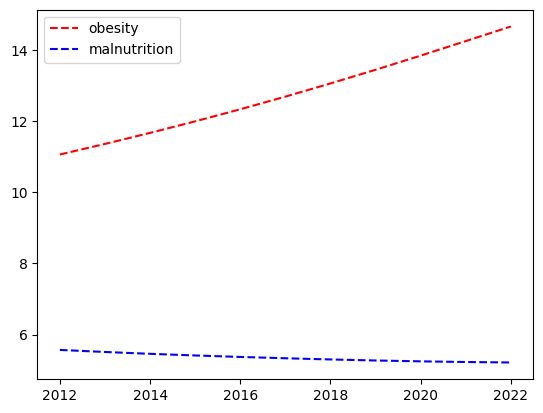

In [79]:
plt.plot(df25['year'],df25['Avg_obesity'],label='obesity', color='red', linestyle='--')
plt.plot(df25['year'],df25['Avg_malnutrition'], label='malnutrition', color='blue', linestyle='--')
plt.legend()
#plt.show()

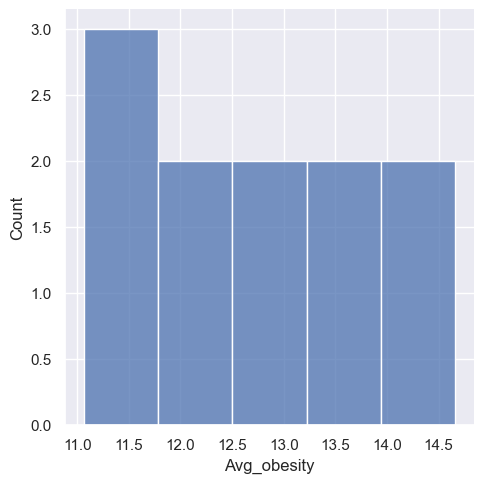

In [80]:
#df25=sns.load_dataset('df25')
sns.set()
sns.displot(df25.Avg_obesity ,kind="hist")


In [81]:
sql27="SELECT     o.year,    MIN(o.Mean_Estimate) AS Min_obesity,    MAX(o.Mean_Estimate) AS Max_obesity,    MIN(m.Mean_Estimate) AS Min_malnutrition,    MAX(m.Mean_Estimate) AS Max_malnutrition FROM     obesity o JOIN     malnutrition m     ON o.country = m.country AND o.year = m.year GROUP BY     o.year ORDER BY     (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) DESC "
cur.execute(sql27)
res27=cur.fetchall()
df26=pd.DataFrame(res27,columns=['year','Min_obesity','Max_obesity','Min_malnutrition','Max_malnutrition'])
df26

,year,Min_obesity,Max_obesity,Min_malnutrition,Max_malnutrition
0,2022,0.483889,80.6093,0.188174,34.2619
1,2021,0.453635,80.3169,0.184717,34.4292
2,2020,0.425986,79.9699,0.181989,34.5784
3,2019,0.400147,79.6005,0.180428,34.7160
4,2018,0.376011,79.2050,0.179796,34.8562
5,2017,0.353319,78.8004,0.179286,34.9979
6,2016,0.332208,78.3959,0.178804,35.1477
7,2015,0.312699,78.0091,0.178445,35.3130
8,2014,0.295133,77.6411,0.177772,35.4982
9,2013,0.279506,77.2977,0.176421,35.6944


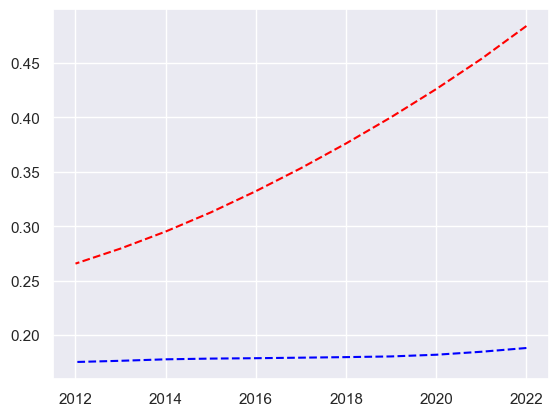

In [82]:
plt.plot(df26['year'],df26['Min_obesity'],label='obesity', color='red', linestyle='--')
plt.plot(df26['year'],df26['Min_malnutrition'], label='malnutrition', color='blue', linestyle='--')